初始化环境

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession # SparkSession 是Spark 2.0版本的新入口
spark = SparkSession.builder.master('local').getOrCreate()

In [2]:
row_data = spark.read.csv(path="hdfs://localhost:9000/user/bdlab/lab2/USCensus1990.data.txt",header=True,inferSchema=True)

data = row_data.rdd

# 0.抽样测试
* 选取最佳k值
* 初始化聚类中心

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [338]:
sample_k_pd = row_data.sample(0.01).toPandas() # 抽样 1%

sample_k_pd = sample_k_pd.iloc[:,1:].values # 第一列无用

In [341]:
# 保存抽样
np.savetxt("sample_std_array.txt",sample_k_pd)

In [5]:
# 加载抽样
sample_k_pd = np.loadtxt("sample_std_array.txt")

样本数据标准化

In [6]:
from sklearn.preprocessing import StandardScaler
stder = StandardScaler()
sample_k_pd = stder.fit_transform(sample_k_pd)

In [4]:
from sklearn.cluster import KMeans

In [51]:
SSE = []  # 存放每次结果的误差平方和
for k in range(1,13):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(sample_k_pd)
    SSE.append(estimator.inertia_)
    print("k={}, SSE={}".format(k,SSE[-1]))

k=1, SSE=1674704.0000000002
k=2, SSE=1328927.7399816418
k=3, SSE=1135042.307368246
k=4, SSE=1067560.372383153
k=5, SSE=1018398.7434226715
k=6, SSE=971948.8169754281
k=7, SSE=943190.3577651557
k=8, SSE=923002.3750831345
k=9, SSE=881972.0964427008
k=10, SSE=870906.5903082998
k=11, SSE=857028.3218245438
k=12, SSE=824949.4245692719


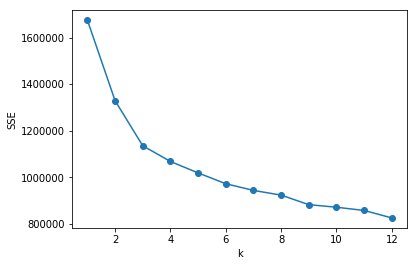

In [52]:
plt.xlabel("k")
plt.ylabel("SSE")
plt.plot(range(1,13),SSE,marker='o')

                根据手肘法,选定k=3或4

### PCA降维,绘图

In [7]:
# PCA拟合,为降维做准备
from sklearn.decomposition import PCA
pca20 = PCA(n_components=20)
sample_k_pca20 = pca20.fit_transform(sample_k_pd)
sum(pca20.explained_variance_ratio_)

0.7776824923882771

In [8]:
estimator = KMeans(n_clusters=4)  # 构造聚类器
estimator.fit(sample_k_pca20)
km_result = estimator.labels_
km_center = estimator.cluster_centers_ # 作为整体数据初始聚类中心

In [9]:
pca2 = PCA(n_components=2)
sample_k_pca2 = pca2.fit_transform(sample_k_pca20)

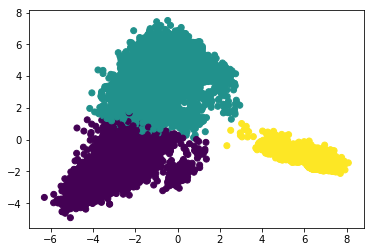

In [345]:
plt.scatter(sample_k_pca2[:,0],sample_k_pca2[:,1],c=km_result)
plt.show()

#### 三维可视化

In [10]:
from sklearn.decomposition import PCA
pca3 = PCA(n_components=3)
sample_k_pca3 = pca3.fit_transform(sample_k_pca20)
pca3.explained_variance_ratio_

array([0.28665664, 0.16149892, 0.08411579])

In [126]:
km_result_dev = [ [[]]*4 for i in range(4) ]
for x,y,z,c in zip(sample_k_pca3[:,0],sample_k_pca3[:,1],sample_k_pca3[:,2],km_result):
    km_result_dev[c][0] = km_result_dev[c][0] +[x]
    km_result_dev[c][1] = km_result_dev[c][1] +[y]
    km_result_dev[c][2] = km_result_dev[c][2] +[z]

#### 不同k,对应分类情况:

k = 4

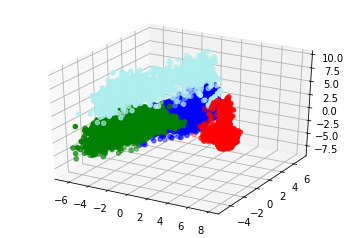

In [127]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(km_result_dev[0][0],km_result_dev[0][1],km_result_dev[0][2],c='r')
ax.scatter(km_result_dev[1][0],km_result_dev[1][1],km_result_dev[1][2],c='b')
ax.scatter(km_result_dev[2][0],km_result_dev[2][1],km_result_dev[2][2],c='g')
ax.scatter(km_result_dev[3][0],km_result_dev[3][1],km_result_dev[3][2],c='#AEEEEE')
plt.show()

k = 5

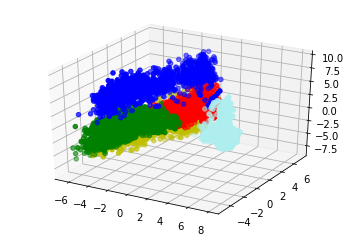

In [121]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(km_result_dev[0][0],km_result_dev[0][1],km_result_dev[0][2],c='r')
ax.scatter(km_result_dev[1][0],km_result_dev[1][1],km_result_dev[1][2],c='b')
ax.scatter(km_result_dev[2][0],km_result_dev[2][1],km_result_dev[2][2],c='g')
ax.scatter(km_result_dev[3][0],km_result_dev[3][1],km_result_dev[3][2],c='#AEEEEE')
ax.scatter(km_result_dev[4][0],km_result_dev[4][1],km_result_dev[4][2],c='y')
plt.show()



# 1.K-Means 聚类

k = 期望簇数

delta = 可接受的收敛误差

max_iter = 最大迭代次数

data = 输入数据


1. 初始化质心

2. map：对每个向量，计算当前向量到各中心的距离，更新最近的中心
    
    输入：向量
    
    输出：（最近的中心，向量）

3. reduce：根据所有map输出，重新计算所有簇的平均值，重新创建质心
    
    输入：iterable 向量
    
    输出：key.id，新质心= avg(list向量)
    
4. change:比较新旧质心的变化，若变化量小于delta，判定收敛，算法终止

    输入：新质心，旧质心
    
    输出：新旧质心距离（向量）
      
       

定义功能函数

In [11]:
# 计算两向量的欧氏距离的平方
def eucDis(x,y):
    return np.sum(np.square(x-y))

# Vector 求和
def vecAdd(x):
    return np.sum(x,axis=0)

# Vector 除以整数
def vecDiv(vec,y):
    return np.divide(vec,y)

# 计算质心变化
def change(new,current):
#     new_d = eucDis(vecAdd(new),vecAdd(current))
    new_d = np.linalg.norm(vecAdd(new)-vecAdd(current))
    return new_d if new_d>=0 else -new_d

# 标准化,降维
def std_pca_mapper(x):
    x = stder.transform([x])[0]
    x = pca20.transform([x])[0]
    return np.asarray(x)

In [12]:
# 参数
k = 4
delta = 0.01
max_iter = 20
initial_centroids = km_center.copy()
current_centroids = initial_centroids.copy()
data = row_data.rdd.map(lambda x:x[1:])

In [19]:
sample_data_rdd = data.sample(False,0.01)
sample_data_rdd.count()

24539

mapper 对Vector分类

In [13]:
def nearest_mapper(tup):
    """
    Parameters:
        tup: input tuple (id,(vec,1))
    Returns:
        nearest: the nearest center id
        x: input x
        1: counter
    """
    x = tup[1][0]
    nearest = -1
    nearest_dis = -1
    for i in range(k):
        dis = eucDis(x,current_centroids[i])
        if nearest == -1:
            nearest = i
            nearest_dis = dis
        else:
            if dis<nearest_dis:
                nearest = i
                nearest_dis = dis 
    return (nearest,(x,1))

reducer 重新计算质心

In [14]:
def center_reducer(x,y):
    return (vecAdd([x[0],y[0]]),x[1]+y[1])

### K-Means

In [15]:
import time

def k_means(data,delta = 0.01,max_iter = 20,initial_centroids = initial_centroids):
    # 初始化迭代计数器
    iter_cnt = 0
    # 初始化簇质心
    global current_centroids
    current_centroids = initial_centroids.copy()
    new_centroids = initial_centroids.copy()
    # 调整数据格式作为输入
    data = data.map(std_pca_mapper).map(lambda x:(0,(x,1)))
    print("STD, PCA complete.")
    time_start = time.time()
    # 迭代
    while True:
        data = data.map(nearest_mapper)
        cent_list = data.reduceByKey(center_reducer).collect()
        for x,y in cent_list: # (id,(vec,cnt))
            new_centroids[x] = vecDiv(y[0],y[1])
        iter_cnt +=1
        loss = change(new_centroids,current_centroids)
        
        # TODO: 输出迭代信息
        time_end = time.time()
        print("Iter {} complete, loss={}, time cost={:.2f}".format(iter_cnt,loss,time_end-time_start))
        time_start = time_end
        
        if loss<delta :
            # 收敛
            print("收敛,算法结束.")
            break;
        if iter_cnt >= max_iter :
            # 达到最大迭代次数
            print("达到迭代上限,算法结束")
            break;
        current_centroids = new_centroids.copy()
    result = data.map(lambda x:x[0]).collect() # 获得label
    return result

In [69]:
sample_np_label = k_means(data=sample_data_rdd)

STD, PCA complete.
Iter 1 complete, loss=49.3076528812191, time cost=25.63
Iter 2 complete, loss=7.380910182038808, time cost=25.30
Iter 3 complete, loss=11.565677693258412, time cost=25.75
Iter 4 complete, loss=2.539370504990537, time cost=27.01
Iter 5 complete, loss=0.24787310988586755, time cost=27.47
Iter 6 complete, loss=0.08310628481822208, time cost=26.02
Iter 7 complete, loss=0.03143822171921578, time cost=24.37
Iter 8 complete, loss=0.017302411375197894, time cost=23.98
Iter 9 complete, loss=0.007965839209723808, time cost=23.96
收敛,算法结束.


In [374]:
result_dev_label = k_means(data=data)

STD, PCA complete.
Iter 1 complete, loss=0.5352455035113454, time cost=403.1133394241333
Iter 2 complete, loss=0.03955999575458704, time cost=491.5321614742279
Iter 3 complete, loss=0.01001300021947135, time cost=659.0231416225433
Iter 4 complete, loss=0.002906212464163813, time cost=708.0721468925476
收敛,算法结束.


In [275]:
result_label = k_means(data=sample_data_rdd)

STD, PCA complete.
Iter 1 complete, loss=48.077954981275674
Iter 2 complete, loss=7.114856227427667
Iter 3 complete, loss=11.367233488964938
Iter 4 complete, loss=3.1399017426652143
Iter 5 complete, loss=0.2869009101544974
Iter 6 complete, loss=0.10953284613082485
Iter 7 complete, loss=0.051221214464351704
Iter 8 complete, loss=0.03564039898084647
Iter 9 complete, loss=0.020925191521223473
Iter 10 complete, loss=0.013084297834233418
Iter 11 complete, loss=0.010420790086677708
Iter 12 complete, loss=0.002630720944236058
收敛,算法结束.


In [378]:
# 保存分类结果
np.save("result_dev_label",np.asarray(result_dev_label))

In [16]:
# 加载分类结果
result_dev_label = np.load("result_dev_label.npy")

### 可视化

In [22]:
vis_data = pd.DataFrame([ std_pca_mapper(_) for _ in  data.take(10000)])
vis_label = result_dev_label[:10000]

In [78]:
vis_data = pd.DataFrame(sample_data_rdd.map(std_pca_mapper).collect())
vis_label = sample_np_label

usdata.pickle 测试

In [11]:
import pickle
with open("usdata.pickle","rb") as usdata:
    pickle_data = pickle.load(usdata)
    
def cluster_result_test(cluster_result):
    y = cluster_result[:10000]
    plt.scatter(pickle_data[:,0],pickle_data[:,1],c=y)
    plt.show()

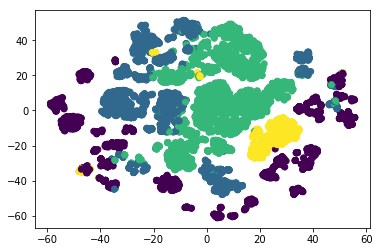

In [12]:
# k=4
cluster_result_test(result_dev_label)

三维

In [30]:
vis_data_3d = pca3.transform(vis_data)

In [31]:
result_dev = [ [[]]*k for i in range(k) ]
for x,y,z,c in zip(vis_data_3d[:,0],vis_data_3d[:,1],vis_data_3d[:,2],vis_label):
    result_dev[c][0] = result_dev[c][0] +[x]
    result_dev[c][1] = result_dev[c][1] +[y]
    result_dev[c][2] = result_dev[c][2] +[z]

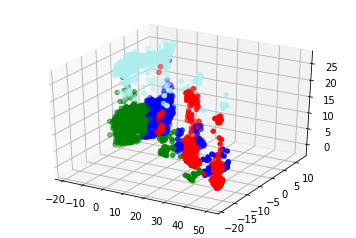

In [32]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(result_dev[0][0],result_dev[0][1],result_dev[0][2],c='r')
ax.scatter(result_dev[1][0],result_dev[1][1],result_dev[1][2],c='b')
ax.scatter(result_dev[2][0],result_dev[2][1],result_dev[2][2],c='g')
ax.scatter(result_dev[3][0],result_dev[3][1],result_dev[3][2],c='#AEEEEE')
plt.show()

抽样kmeans 结果

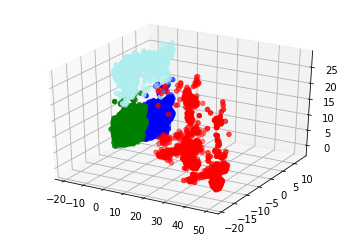

In [363]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(result_dev[0][0],result_dev[0][1],result_dev[0][2],c='r')
ax.scatter(result_dev[1][0],result_dev[1][1],result_dev[1][2],c='b')
ax.scatter(result_dev[2][0],result_dev[2][1],result_dev[2][2],c='g')
ax.scatter(result_dev[3][0],result_dev[3][1],result_dev[3][2],c='#AEEEEE')
plt.show()

二维

In [25]:
vis_data_2d = pca2.transform(vis_data)

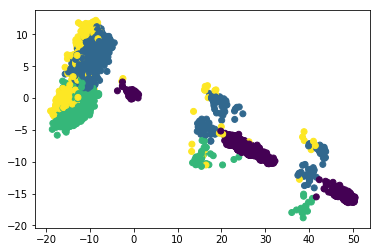

In [26]:
plt.scatter(vis_data_2d[:,0],vis_data_2d[:,1],c=np.asarray(vis_label))
plt.show()

抽样kmeans结果

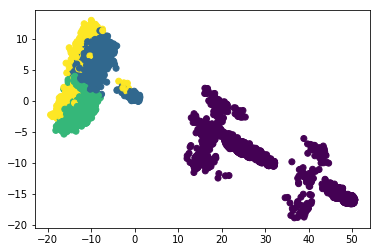

In [359]:
plt.scatter(sample_pca2[:,0],sample_pca2[:,1],c=np.asarray(result_label))
plt.show()

# K-medoids

In [22]:
# 参数
k_med = 4
delta_med = 0.01
max_iter_med = 20
initial_centroids_med = km_center.copy()
current_centroids_med = km_center.copy()
data = row_data.rdd.map(lambda x:x[1:])

In [85]:
# 根据k-means中心,获得初始中心对象
minDis = [-1]*k_med
minIds = [[]]*k_med

def min_dis_feh(x):
    for i in range(k_med):
        dis = eucDis(x,initial_centroids_med[i])
        if minDis[i]==-1:
            minDis[i] = dis
            minIds[i] = x
        elif dis<minDis[i]:
            minDis[i] = dis
            minIds[i] = x 
            return
            
def get_centroids_med(data):
    for x in data:
        min_dis_feh(x)
    return minIds   

In [69]:
sample_data_list=sample_data_rdd.map(std_pca_mapper).collect()

In [86]:
get_centroids_med(data=sample_data_list);

[array([ 0.42998006,  0.00977808,  3.94984244,  2.24971548,  2.63131374,
        -0.59282072,  1.14106714, -2.14391658,  1.45468873, -0.90677131,
         0.2384684 ,  1.65878937, -0.43064495, -0.78040767,  0.4965817 ,
         0.30470713,  0.19203072,  0.27469835,  0.39538502, -0.059962  ]),
 array([ 0.70325557,  0.54003766,  4.64570614,  1.12204992,  1.32064146,
         0.09151378,  3.02207304, -2.04949498,  1.53023526, -1.52692435,
         1.23931292,  1.86893625, -0.03840048, -1.36686987,  0.75217089,
        -0.43253396,  0.56348937,  0.63026586,  0.02365186,  0.07165828]),
 array([-3.65234046,  0.92134624,  3.05563389,  1.80470783,  1.7355515 ,
        -1.85167389,  0.797052  , -4.24360095,  1.64215378,  1.64258298,
         0.05126584,  0.51051986,  0.41737035, -0.95168292, -0.72454352,
        -0.06155058,  0.94268088,  0.05996165,  0.50676006, -0.14305773]),
 array([-0.07596769,  0.37853971,  7.52117313,  5.29207494,  2.22451224,
        -1.16806847,  1.74840139, -3.13015367

In [123]:
# 把每个对象划分到新的簇
def nearest_med_mapper(tup):
    """
    Parameters:
        tup: input tuple (id,[vec])
    Returns:
        nearest: the nearest center id
        x: input vec
    """
    x = tup[1][0]
    nearest = -1
    nearest_dis = -1
    for i in range(k_med):
        dis = eucDis(x,current_centroids_med[i])
        if nearest == -1:
            nearest = i
            nearest_dis = dis
        else:
            if dis<nearest_dis:
                nearest = i
                nearest_dis = dis 
    return (nearest,[x])

In [98]:
random.randrange(seeds)

47

In [128]:
# 计算新的簇
import random
seeds = 50
def center_med_reducer(x,y):
    if len(x) < seeds:
        return x+y
    else:
        # TODO 修正水库抽样
        x[random.randrange(seeds)]=y[0]
        return x

In [119]:
test = spark.sparkContext.parallelize(sample_data_list[:1000])

In [120]:
test.take(3)

[array([-13.53642957,  -1.26285053,   4.59015075,  -1.38843808,
         -1.06585429,  -0.44018376,   4.05667692,  -2.82761683,
          4.49596184,   2.55860534,   1.74955579,   1.4590386 ,
          1.82235123,  -2.37374569,  -0.14356958,   0.44534826,
         -0.12304593,   0.45566561,  -0.15068052,   0.68597382]),
 array([ 27.14587006,  -8.86718661,   2.33232877,   4.19972028,
          3.52752599,   3.02697304,  -1.52790339, -10.83109251,
          3.50154841,   9.5195933 ,   3.50817165,   4.17680027,
          3.2540333 ,  -8.33474415, -10.39997407,  -2.27836692,
         -1.7667728 ,   6.49987912,  -2.1966252 ,   2.57768056]),
 array([-12.78512158,   4.86981154,   8.76336763,   2.25994366,
          0.87884931,  -1.41395145,   4.10431934,  -3.72661477,
          2.06751382,   4.94146941,   3.01949654,  -2.2893415 ,
          5.06767234,  -5.90283677,   0.05419412,  -0.56902225,
         -0.14655782,   0.81287072,  -0.45456112,   0.86977556])]

In [129]:
test_collect = test.map(lambda x:(0,[x])).map(nearest_med_mapper).reduceByKey(center_med_reducer).collect()

In [131]:
test_collect[1][1]

[array([ 19.89416404,  -2.72533641,   7.74902409,   6.37910521,
          7.12836876,   0.84803842,  -1.8000341 , -14.36245446,
          4.48137838,   8.81601558,   2.72337535,   5.61975504,
          2.34634313, -10.07866929, -12.60566351,  -3.23350118,
         -2.27523915,   7.70031216,  -1.68642648,   3.82238777]),
 array([ 27.06213965,  -8.01241734,   7.44947751,   6.55686671,
          2.31785794,   2.96456877,   1.27113373, -11.72804328,
          4.0105605 ,   9.54471467,   4.21378608,   4.35480533,
          3.92902606,  -9.64057098,  -9.80450141,  -1.87506503,
         -1.3248551 ,   6.69580186,  -2.60523012,   2.45244428]),
 array([ 25.49895977,  -8.34026376,   6.71371237,   7.16626878,
          4.61879049,   1.20917695,  -0.03378326, -13.7534424 ,
          4.64058151,  11.46426235,   2.93877248,   2.318691  ,
          3.9068193 ,  -9.09127454, -10.18410074,  -1.56855009,
         -1.46712724,   6.20442119,  -3.0362321 ,   2.62020236]),
 array([ 39.72372806, -12.30163087

In [133]:
# 获得当前cluster的新中心点
def get_centroids_med(cluster):
    
    

SyntaxError: unexpected EOF while parsing (<ipython-input-133-55e12dc8f3e4>, line 2)

In [ ]:
import time

def k_medoids(data,initial_centroids_med=minIds,iter_cnt=iter_cnt):
    # 初始化迭代计数器
    iter_cnt = 0
    # 初始化簇质心
    global current_centroids_med
    current_centroids_med = initial_centroids_med.copy()
    new_centroids_med = initial_centroids_med.copy()
    # 调整数据格式作为输入
    data = data.map(std_pca_mapper).map(lambda x:(0,[x]))
    print("STD, PCA set.")
    time_start = time.time()
    # 迭代
    while True:
        # 划分簇
        data = data.map(nearest_med_mapper)
        # 计算新的中心
        cluster_collect = data.reduceByKey(center_med_reducer).collect()
        cent_list = 
        for x,y in cent_list: # (id,(vec,cnt))
            new_centroids[x] = vecDiv(y[0],y[1])
        iter_cnt +=1
        loss = change(new_centroids,current_centroids)
        
        # TODO: 输出迭代信息
        time_end = time.time()
        print("Iter {} complete, loss={}, time cost={:.2f}".format(iter_cnt,loss,time_end-time_start))
        time_start = time_end
        
        if loss<delta :
            # 收敛
            print("收敛,算法结束.")
            break;
        if iter_cnt >= max_iter :
            # 达到最大迭代次数
            print("达到迭代上限,算法结束")
            break;
        current_centroids = new_centroids.copy()
    result = data.map(lambda x:x[0]).collect() # 获得label
    return result